In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import random

import torch
from torch import nn, optim 
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns


import os
os.environ['PYTHONHASHSEED'] = str(42)
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from fast_ml.model_development import train_valid_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

In [3]:
df = pd.read_csv('BabayanEtAl_VirusData.csv')
#print(df.describe())

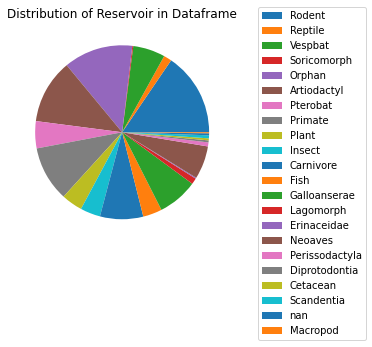

In [4]:
reservoir_types = {}
for host in df['Reservoir']:
    if host in reservoir_types.keys():
        reservoir_types[host] += 1
    else:
        reservoir_types[host] = 1
#print(reservoir_types)
labels = list(reservoir_types.keys())
counts = list(reservoir_types.values())
plt.pie(counts,labels=labels, labeldistance=None)
ax = plt.gca()
plt.legend(bbox_to_anchor=(1.1, 1.1), bbox_transform=ax.transAxes)
plt.title('Distribution of Reservoir in Dataframe')
plt.show()

# Showing only vector-borne transmission

In [5]:
df = df[df['Reservoir'].notna()] #remove nan from reservoir
df.drop(columns = ['Virus name', 'Genbank accession', 'Viral group', 'Reservoir', 'Vector'], inplace = True)


print(df.head())

  Vector-borne       CpG       UpA       ApA       ApC       ApG       ApU  \
0            0  0.273332  0.610948  1.008116  0.982968  1.102821  0.916422   
1            0  0.271883  0.556632  1.147643  0.963959  1.077809  0.806347   
2            0  0.242131  0.480134  1.079250  0.981423  1.040453  0.889428   
3            0  0.197870  0.606717  1.060972  0.955761  1.097001  0.888032   
4            0  0.186029  0.535157  1.059094  1.015957  1.034448  0.889518   

        CpA       CpC       CpU  ...  TCG.Bias  TCT.Bias  TGA.Bias  TGC.Bias  \
0  1.410025  1.024852  1.117820  ...  0.039711  0.198556      0.00  0.402174   
1  1.283400  1.105659  1.197583  ...  0.018519  0.303704      0.25  0.303030   
2  1.445752  0.947255  1.189313  ...  0.054348  0.130435      0.50  0.320000   
3  1.306677  1.098326  1.179541  ...  0.029508  0.209836      0.00  0.318681   
4  1.407899  1.032459  1.133332  ...  0.054348  0.195652      0.50  0.269231   

   TGG.Bias  TGT.Bias  TTA.Bias  TTC.Bias  TTG.Bia

In [6]:
print('# Entries in prefiltered data = {}'.format(len(df)))

# Entries in prefiltered data = 534


In [7]:
df.drop(df[df['Vector-borne'] == '?'].index, inplace = True)
df.drop(df[df['Vector-borne'] == ''].index, inplace = True)

print('# Entries after removing ? and NA vector-borne columns = {}'.format(len(df)))
print('Presence of Empty or ? Vector-borne Columns = {}'.format(df['Vector-borne'].notna().sum() == 0))

# Entries after removing ? and NA vector-borne columns = 525
Presence of Empty or ? Vector-borne Columns = False


In [8]:
## The dataframe column stores str values of 0 and 1. Convert to int

df['Vector-borne'] = df['Vector-borne'].astype(int) 
df['Vector-borne'] = df['Vector-borne'].astype(int)

# Visualising List of Features (Cols)

In [9]:
feature_list = list(df.columns)
feature_list = feature_list[1:] # remove first entry which is 'Reservoir'
print(len(feature_list))
print(feature_list)

4229
['CpG', 'UpA', 'ApA', 'ApC', 'ApG', 'ApU', 'CpA', 'CpC', 'CpU', 'GpA', 'GpC', 'GpG', 'GpU', 'UpC', 'UpG', 'UpU', 'brApA', 'brApC', 'brApG', 'brApU', 'brCpA', 'brCpC', 'brCpG', 'brCpU', 'brGpA', 'brGpC', 'brGpG', 'brGpU', 'brUpA', 'brUpC', 'brUpG', 'brUpU', 'NonBrApA', 'NonBrApC', 'NonBrApG', 'NonBrApU', 'NonBrCpA', 'NonBrCpC', 'NonBrCpG', 'NonBrCpU', 'NonBrGpA', 'NonBrGpC', 'NonBrGpG', 'NonBrGpU', 'NonBrUpA', 'NonBrUpC', 'NonBrUpG', 'NonBrUpU', 'AAA.K..AAA.K.', 'AAA.K..AAC.N.', 'AAA.K..AAG.K.', 'AAA.K..AAT.N.', 'AAA.K..ACA.T.', 'AAA.K..ACC.T.', 'AAA.K..ACG.T.', 'AAA.K..ACT.T.', 'AAA.K..AGA.R.', 'AAA.K..AGC.S.', 'AAA.K..AGG.R.', 'AAA.K..AGT.S.', 'AAA.K..ATA.I.', 'AAA.K..ATC.I.', 'AAA.K..ATG.M.', 'AAA.K..ATT.I.', 'AAA.K..CAA.Q.', 'AAA.K..CAC.H.', 'AAA.K..CAG.Q.', 'AAA.K..CAT.H.', 'AAA.K..CCA.P.', 'AAA.K..CCC.P.', 'AAA.K..CCG.P.', 'AAA.K..CCT.P.', 'AAA.K..CGA.R.', 'AAA.K..CGC.R.', 'AAA.K..CGG.R.', 'AAA.K..CGT.R.', 'AAA.K..CTA.L.', 'AAA.K..CTC.L.', 'AAA.K..CTG.L.', 'AAA.K..CTT.L.', 'A

# Model

In [12]:
class DiseaseNN(nn.Module):
    def __init__(self):
        super(DiseaseNN, self).__init__()
        
        #### Inputs passed in following order of applied functions
        self.fc = nn.Sequential(
            nn.Linear(4229, 1024), 
            nn.ReLU(), 
            nn.Dropout(0.2),
            
            nn.Linear(1024, 512), 
            nn.ReLU(), 
            nn.Dropout(0.2),
            
            nn.Linear(512, 128), 
            nn.ReLU(), 
            nn.Dropout(0.2),
            
            nn.Linear(128, 2), 
            nn.Softmax(dim=1)
        )
        
        
    def forward(self, x):
        return self.fc(x)


################ METHOD to train model ########################    
def train(model, epochs, optimizer, loss_fnc, X_train, y_train_1_hot, X_val, y_val_1_hot, patience):
    
    best_epoch = -1
    prev_epoch_loss = 100
    stagnant_count = 0
    training_losses = []
    
    
    for epoch in range(1, epochs):
        optimizer.zero_grad() #reset gradients after each epoch
        model.train()
        output = model(X_train)
        loss = loss_fnc(output, y_train_1_hot)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
        
        val_loss = validate(model=model, loss_fnc=loss_fnc, X_val=X_val, y_val_1_hot=y_val_1_hot)
        
        if val_loss > prev_epoch_loss: # later epochs did not show improvement
            stagnant_count += 1
        
            if stagnant_count >= patience:
                best_epoch = epoch
                print('Early Stopped, best Epoch = {}'.format(best_epoch))
                break
    
        else: # achieve record lower loss, reset the process
            best_epoch = epoch
            stagnant_count = 0
            
        prev_epoch_loss = val_loss
        
    return [model, training_losses, best_epoch]


############# Method to get validation loss during training ##############
def validate(model, loss_fnc, X_val, y_val_1_hot):
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = loss_fnc(val_output, y_val_1_hot)
    return val_loss
    
    
    
############## Method to test model #####################
def test(model, X_test, y_test):
    y_test_truth = torch.tensor(y_test.to_numpy()).float()
    model.eval()
    with torch.no_grad():
        y_test_predicted = model(X_test) # 1 hot encoding representation
        y_test_predicted = torch.argmax(y_test_predicted, 1) # get actual prediction in 1D format
        test_accuracy = accuracy_score(y_test_truth, y_test_predicted)
    
    y_test_truth = y_test_truth.tolist()
    y_test_predicted = y_test_predicted.tolist()
    return test_accuracy, y_test_predicted, y_test_truth





########## METHOD TO GET X_train, y_train, X_val, y_val, X_test, y_test, y_train_one_hot, y_val_one_hot ##########
def get_data(target_df):
    X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(target_df, 
                                                                            target = 'Vector-borne', 
                                                                            train_size=0.7, 
                                                                            valid_size=0.1, 
                                                                            test_size=0.2, 
                                                                            random_state=42) # reproducible seed
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train) # it transforms and then fit, so its additive
    X_test = scaler.transform(X_test) #so that the model does not learn this set of test data
    X_val = scaler.transform(X_val)

    X_train = torch.tensor(X_train).float()
    X_test = torch.tensor(X_test).float()
    X_val = torch.tensor(X_val).float()

    one_hot_train, y_train_list = [], []

    ########## For Training ################
    for ele in y_train:
        ans = [0.0, 0.0]
        ans[ele] = float(1) # one-hot encoding ---- e.g for df_0, [0, 1] = sample is Rodent, [1, 0] = sample NOT RODENT
        one_hot_train.append(ans)
        y_train_list.append(ele)


    ########## For Validation #############    
    one_hot_val, y_val_list = [], []

    for ele in y_val:
        ans2 = [0.0, 0.0]
        ans2[ele] = float(1) # one-hot encoding for validation
        one_hot_val.append(ans2)
        y_val_list.append(ele)


    y_train_one_hot = torch.tensor(one_hot_train) # to compute loss against NN output
    y_train = torch.tensor(y_train_list) # for accuracy calculation

    y_val_one_hot = torch.tensor(one_hot_val) # to compute loss against NN output
    y_val = torch.tensor(y_val_list) # for accuracy calculation
    
    return X_train, y_train, X_val, y_val, X_test, y_test, y_train_one_hot, y_val_one_hot

# Visualising Feature Importance

### For Vector-borne --- Class 0 = 0, Class 1 = Vector Borne

In [15]:
shap.initjs()

model = DiseaseNN()
adam_optim = optim.Adam(model.parameters(), lr=0.001)
bce_loss = nn.BCELoss()
num_epochs = 100

X_train, y_train, X_val, y_val, X_test, y_test, y_train_one_hot, y_val_one_hot = get_data(df)

results = train(model=model, 
                    epochs=num_epochs, 
                    optimizer=adam_optim, 
                    loss_fnc=bce_loss, 
                    X_train=X_train, 
                    y_train_1_hot=y_train_one_hot, 
                    X_val=X_val, 
                    y_val_1_hot=y_val_one_hot,
                    patience=10
                   )

e = shap.DeepExplainer(model=model, data=X_train)


test_accuracy, y_test_pred, y_test_truth = test(model=model, X_test=X_test, y_test=y_test)

print('Testing Accuracy = {}, Best Epoch = {}'.format(test_accuracy, results[2]))


Early Stopped, best Epoch = 69
Testing Accuracy = 0.8301886792452831, Best Epoch = 69


In [16]:
shap_val = e.shap_values(X=X_test)

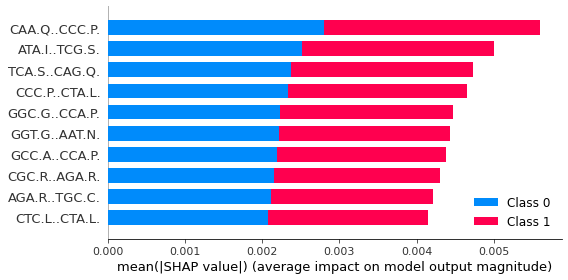

In [17]:
shap.summary_plot(shap_val, features=X_train, feature_names=feature_list, max_display=10, plot_size=[8,4])


[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

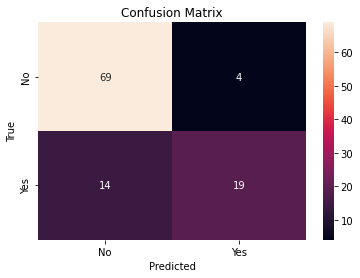

In [18]:
ax = plt.subplot()
cm = confusion_matrix(y_test_truth, y_test_pred)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
classLabels = ['No', 'Yes']
ax.xaxis.set_ticklabels(classLabels)
ax.yaxis.set_ticklabels(classLabels)

In [19]:
# Overall stats (Weighted)
print(f'Accuracy: {accuracy_score(y_test_truth, y_test_pred)}')
print(f"Precision: {precision_score(y_test_truth, y_test_pred, average='weighted')}")
print(f"Recall: {recall_score(y_test_truth, y_test_pred, average='weighted')}")
print(f"F1: {f1_score(y_test_truth, y_test_pred, average='weighted')}")

Accuracy: 0.8301886792452831
Precision: 0.8296944957846151
Recall: 0.8301886792452831
F1: 0.8204696247149077
